# British Airways Reviews Analysis

Notebook 3: Topic Modeling with BERTopic


In [1]:
import os
import warnings
import openai
import tiktoken
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from hdbscan import HDBSCAN
from umap import UMAP
from matplotlib import cm
from IPython.display import display, Markdown

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

os.environ["TOKENIZERS_PARALLELISM"] = "true"

openai_api_key = os.getenv("OPENAI_API_KEY")

In [2]:
data = pd.read_csv("../data/airline_reviews_clean.csv")

df = data[["rating", "review_text", "title", "review_locations"]]

docs = df["review_text"].apply(str.lower).tolist()

print("Total reviews: ", len(docs))

Total reviews:  2304


BERTopic is a topic modeling framework using transformers. It uses a sequence of sub-models to create topic representations:

- Embedding Model: `SentenceTransformers` converts text documents into numerical representations.
- Dimensionality Reduction Model: `UMAP` reduces embedding dimensions to prepare for clustering.
- Clustering Model: `HDBSCAN` groups similar documents into clusters.
- Vectorization Model: `CountVectorizer` transforms documents into word frequency representations.
- Representation Model: `ClassTfidfTransformer` identifies and ranks defining words for each topic.

To improve the results, we'll also add these additional representation models:

- `KeyBERTInspired`: Extracts keywords and refines topics based on `ClassTfidfTransformer` outputs.
- `MaximalMarginalRelevance`: maximizes diversity of words within each topic, reducing redundancy.
- `OpenAI`: GPT-4o-mini provides custom topic labels.


In [3]:
# Sub-models for BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="mps")

embeddings = embedding_model.encode(docs, show_progress_bar=True)

hdbscan_model = HDBSCAN(min_cluster_size=10, metric="euclidean", cluster_selection_method="eom", prediction_data=True)

umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric="cosine", random_state=0)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)


def get_representation_model():
    """
    Initializes the BERTopic representation models:
    - KeyBERTInspired: Keyword extraction like KeyBERT algorithm.
    - MaximalMarginalRelevance: Uses MMR for diversity in keyword selection.
    - OpenAI: Generates topic labels with GPT-4o-mini.

    Returns:
        dict: A dictionary with the key "openai" and associated models.
    """
    prompt = """
    Your task is to create a descriptive label for a collection of British Airways customer reviews based on the review content and keywords provided below.

    Label requirements:
    1. Reflect the topic of the reviews in 5 words or less.
    2. Be specific to the topic and not generic.
    3. Assist the airline in evaluating their performance and identifying areas of improvement.

    Examples:
    * Bad Labels (too generic): Customer Experience with British Airways, Customer Experience on Flights, Vancouver to London Flight Experience.
    * Good Labels: Fast Check-in and Friendly Staff, Flight Delays and Meal Issues, Baggage Handling Issues.

    Respond in this format:
    topic: <label>

    Keywords:
    [KEYWORDS]

    Reviews:
    [DOCUMENTS]
    """

    tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

    client = openai.OpenAI(api_key=openai_api_key)
    openai_model = OpenAI(
        client,
        model="gpt-4o-mini",
        delay_in_seconds=2,
        chat=True,
        nr_docs=4,
        doc_length=1024,
        tokenizer=tokenizer,
        prompt=prompt,
    )

    keybert = KeyBERTInspired()
    mmr = MaximalMarginalRelevance(diversity=0.3)

    return {
        # "main": [keybert, mmr],
        "openai": [keybert, mmr, openai_model],
    }


# find single words and bigrams
n_gram_range = (1, 2)


def get_vectorizer_model():
    """
    Initializes the CountVectorizer model for BERTopic with custom stopwords.

    Returns:
        CountVectorizer: Configured vectorizer model.
    """
    stop_words = stopwords.words("english")
    stop_words.extend(["airline", "flight", "ba", "british", "airways"])
    stop_words.extend([str(loc).lower() for loc in df["review_locations"].apply(list).explode().unique().tolist()])

    return CountVectorizer(stop_words=stop_words, ngram_range=n_gram_range)


def get_topic_model():
    """
    Initializes the main BERTopic model with the configured sub-models.

    Returns:
        BERTopic: Configured BERTopic model.
    """
    return BERTopic(
        vectorizer_model=get_vectorizer_model(),
        representation_model=get_representation_model(),
        ctfidf_model=ctfidf_model,
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=10,
        nr_topics="auto",
        n_gram_range=n_gram_range,
    )

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

In [4]:
def train_topic_model():
    """
    Trains the BERTopic model on the customer reviews.

    Returns:
        BERTopic: The trained BERTopic model.
    """
    topic_model = get_topic_model()

    print("Training model...")
    topics, probs = topic_model.fit_transform(docs, embeddings)

    df["topic"] = topics
    df["topic_prob"] = probs

    return topic_model

In [5]:
topic_model = train_topic_model()

Training model...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# make topic labels from OpenAI representation
labels = topic_model.generate_topic_labels(aspect="openai", topic_prefix=False)
topic_model.set_topic_labels(labels)

# merge topic info with main dataframe
topic_label_df = pd.DataFrame({
    "topic": topic_model.topic_labels_.keys(),
    "topic_label": labels,
})
df = df.merge(topic_label_df, left_on="topic", right_on="topic", how="left")

### Visualizations


#### Topic Datamap

This plot visualizes the relationships between topics. Each cluster represents a group of similar reviews, with the density of points indicating the concentration of documents within that topic. The labeled areas highlight the dominant topics within each cluster, and the proximity between clusters suggests semantic similarity between those topics.


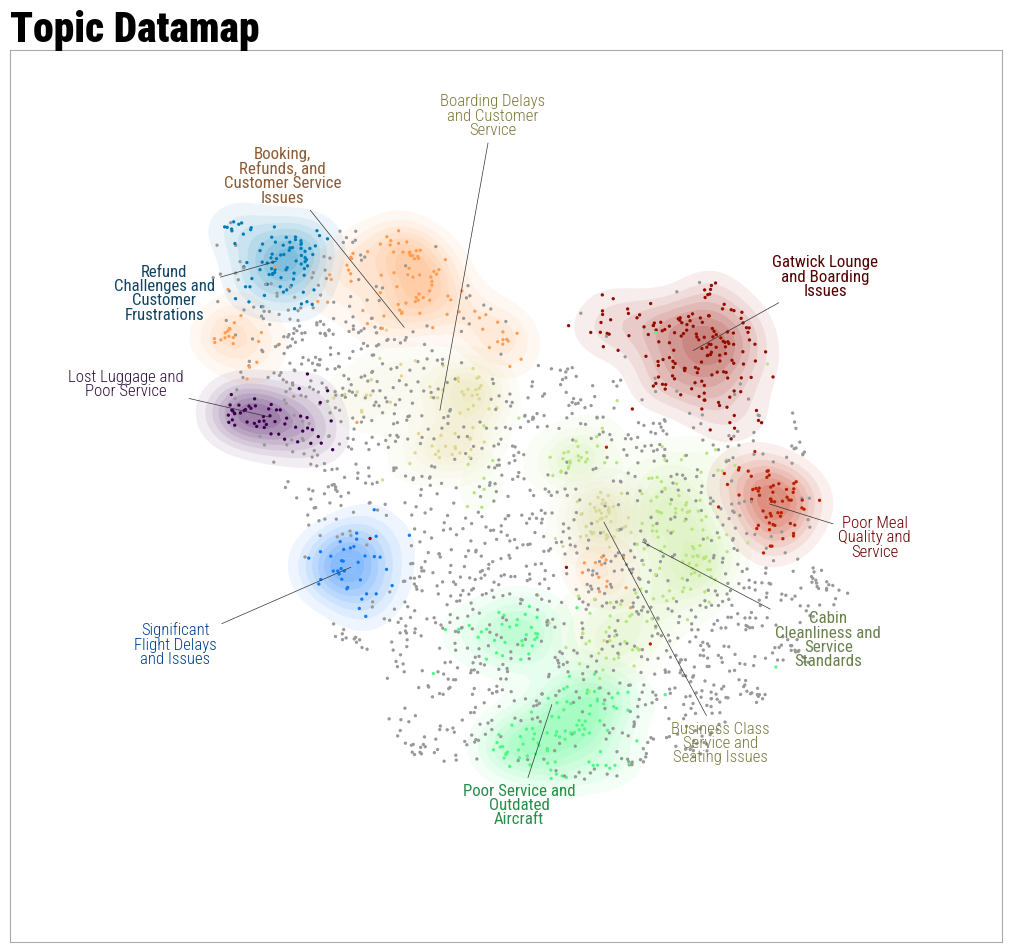

In [7]:
datamap = topic_model.visualize_document_datamap(
    docs,
    embeddings=embeddings,
    height=900,
    width=1000,
    title="Topic Datamap",
    custom_labels=True,
    dynamic_label_size=True,
    topics=range(0, 10),
    max_font_size=48,
    min_font_size=12,
    min_font_weight=300,
    max_font_weight=500,
    font_family="Roboto Condensed",
    cmap=cm.turbo,
    darkmode=False,
)

#### Topics per class bar chart

This plot shows the frequency distribution of the top topics across positive, neutral, and negative rating classes. Each bar represents the frequency of that topic within its class. Double click labels in the legend to toggle the visibility of the other topics.


In [8]:
# Add rating class to dataframe to visualize topics per class
df["rating_class"] = df["rating"].apply(lambda x: "positive" if x > 7 else "neutral" if x > 4 else "negative")
topics_per_class = topic_model.topics_per_class(docs, df["rating_class"].tolist(), global_tuning=True)

topic_model.visualize_topics_per_class(
    topics_per_class,
    custom_labels=True,
    width=1000,
    height=600,
    top_n_topics=10,
    title="Top 10 Topics per Rating Class",
)

#### All Topics Visualization

This one is similar to the datamap but shows all topics and is interactive. Hovering over each data point will show the title of the review associated with it.


In [9]:
topic_model.visualize_documents(
    df["title"].tolist(),
    embeddings=embeddings,
    width=1000,
    title="All Topics",
    custom_labels=True,
    hide_annotations=True,
)

#### Topic Top Words

This plot show the top words in each of the top 8 topics. The size of each bar indicates the word's c-TF-IDF score, which is a measure of the word's importance within the topic.


In [10]:
topic_model.visualize_barchart(title="Topic Top Words", autoscale=True, width=250)

#### Bubble chart

This visualization displays the distribution of topics in a 2-dimensional space using bubbles. The size of each bubble indicates how often the topic appears in the documents. The distance between bubbles represents semantic relationship between the topics, with topics that share common words appearing closer together and overlapping.


In [11]:
topic_model.visualize_topics(title="All Topics", custom_labels=True)

#### Rating and Count by Topic


In [20]:
df_topics = df[df["topic"] > -1]

avg_rating_by_topic = df_topics.groupby("topic_label")["rating"].mean().reset_index()
avg_rating_by_topic_sorted = avg_rating_by_topic.sort_values(by="rating", ascending=False)
topic_label_counts = df_topics["topic_label"].value_counts().reset_index()
topic_label_counts.columns = ["topic_label", "count"]

merged_data = avg_rating_by_topic_sorted.merge(topic_label_counts, on="topic_label")


fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(
    go.Bar(
        y=merged_data["rating"],
        x=merged_data["topic_label"],
        name="Average Rating",
    ),
    row=1,
    col=1,
)

fig.add_trace(go.Bar(y=merged_data["count"], x=merged_data["topic_label"], name="Count"), row=2, col=1)


fig.update_layout(
    xaxis_tickangle=-45, height=600, width=1000, title_text="Rating and Count by Topic", showlegend=False
)
fig.update_yaxes(title_text="Avg. Rating", row=1, col=1, title_standoff=15)
fig.update_yaxes(title_text="Review Count", row=2, col=1, title_standoff=5)
fig.update_xaxes(tickangle=-45)
fig.show()

### tl;dr All topic info


In [13]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,openai,Representative_Docs
0,-1,1027,-1_london_heathrow_staff_seat,Flight Delays and Cancelled Connections,"[london, heathrow, staff, seat, service, crew,...",[Flight Delays and Cancelled Connections],[vancouver to barcelona via heathrow with brit...
1,0,172,0_first_first class_cabin_crew,Cabin Cleanliness and Service Standards,"[first, first class, cabin, crew, food, class,...",[Cabin Cleanliness and Service Standards],[bangkok to london heathrow. boarding was the ...
2,1,161,1_gatwick_lounge_london gatwick_gatwick surrey,Gatwick Lounge and Boarding Issues,"[gatwick, lounge, london gatwick, gatwick surr...",[Gatwick Lounge and Boarding Issues],[gatwick to orlando return. worst ever long-ha...
3,2,125,2_good_entertainment_great_bangkok,Poor Service and Outdated Aircraft,"[good, entertainment, great, bangkok, london, ...",[Poor Service and Outdated Aircraft],[los angeles to london heathrow. the inflight ...
4,3,119,3_paid_customer_seats_told,"Booking, Refunds, and Customer Service Issues","[paid, customer, seats, told, seat, booked, re...","[Booking, Refunds, and Customer Service Issues]",[i booked and bought an online ticket for a mu...
5,4,84,4_refund_cancelled_voucher_cancel,Refund Challenges and Customer Frustrations,"[refund, cancelled, voucher, cancel, phone, ca...",[Refund Challenges and Customer Frustrations],"[ba cancelled my flight, i never got on it, co..."
6,5,63,5_chicken_served_meal_curry,Poor Meal Quality and Service,"[chicken, served, meal, curry, food, breakfast...",[Poor Meal Quality and Service],[london heathrow to phoenix. i have been flyin...
7,6,59,6_hand_bags_bag_luggage,Boarding Delays and Customer Service,"[hand, bags, bag, luggage, help, hand luggage,...",[Boarding Delays and Customer Service],[i was supposed to fly with aeroflot on the 23...
8,7,53,7_luggage_suitcase_bag_dublin,Lost Luggage and Poor Service,"[luggage, suitcase, bag, dublin, bags, claim, ...",[Lost Luggage and Poor Service],[london to dublin. it was never my choice to f...
9,8,45,8_business class_class_business_seats,Business Class Service and Seating Issues,"[business class, class, business, seats, econo...",[Business Class Service and Seating Issues],[absolutely pathetic business class product. b...


In [14]:
client = openai.OpenAI(api_key=openai_api_key)
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "system",
            "content": """You are an advanced text analysis assistant. Your role is to provide concise insights from a given text. Follow these guidelines:

            1. Read the provided text carefully to understand its context and main themes.
            2. Identify and extract key points, including main ideas, arguments, and conclusions.
            3. Analyze the text for any notable patterns, trends, or anomalies.
            4. Provide your insights, including summaries, sentiment analysis, and any connections or implications.
            5. Where applicable, offer recommendations or suggest actions based on your analysis.""",
        },
        {
            "role": "user",
            "content": "\n".join(labels),
        },
    ],
)

In [15]:
display(Markdown(completion.choices[0].message.content))

### Key Points and Insights

1. **Frequent Issues**: The text highlights recurring problems in air travel, such as **flight delays**, **cancellations**, **poor service**, **cleanliness**, **meal quality**, and **customer service challenges**.

2. **Customer Frustration**: There are notable themes of **frustration** regarding **refund processes**, **lost luggage**, and **booking difficulties**, suggesting a trend in negative passenger experiences.

3. **Diverse Experiences**: Various aspects of air travel are examined, from **specific aircraft experiences (Boeing 787, A380)** to **service class distinctions** (Premium Economy, Business Class), indicating a wide range of customer expectations and satisfactions.

4. **Cabin Crew Praise**: **Exceptional support from cabin crew** is noted, contrasting sharply with the criticism of other service aspects, suggesting that personnel can significantly influence customer perceptions.

5. **Check-in and Boarding Challenges**: Issues with **efficient check-in** and **boarding processes** frequently occur, indicating operational inefficiencies that can affect overall passenger satisfaction.

6. **Lounge and Catering Experiences**: The quality of **lounge facilities** and **in-flight catering** appears inconsistent, leading to dissatisfaction among travelers who expect a certain standard, especially in premium classes.

### Sentiment Analysis

- The overall sentiment expressed in the text leans **negative**, reflecting a strong sense of dissatisfaction among passengers regarding multiple facets of their travel experience.
- Despite some positive feedback regarding cabin crew support, the overarching issues appear to overshadow these positive highlights.

### Connections and Implications

- The frequent references to service failures and operational inefficiencies may imply a need for the airline industry to reevaluate its **customer service training**, **logistics management**, and **quality control measures**.
- Discrepancies in service between different classes of travel (e.g., Premium Economy vs. Business Class) may necessitate a reassessment of service standards to ensure that all customers, irrespective of ticket class, receive an acceptable level of service.

### Recommendations

1. **Enhance Customer Service Training**: Focus on improving customer interaction skills for ground staff and cabin crew to alleviate service-related frustrations.
  
2. **Streamline Refund Processes**: Develop a more efficient system for handling refunds to minimize passenger anxiety and dissatisfaction.

3. **Upgrade Aircraft and Services**: Invest in maintaining aircraft and modernizing outdated services (e.g., meal quality, inflight entertainment) to meet contemporary customer expectations.

4. **Address Boarding and Check-in Efficiency**: Implement systems to enhance the efficiency of boarding procedures and check-in processes to reduce delays and improve passenger flow.

5. **Regular Feedback Collection**: Institute regular surveys and feedback mechanisms to capture passenger experiences and address areas needing improvement proactively.

By addressing these key issues, airlines can significantly improve overall customer satisfaction and loyalty.

In [16]:
df.merge(data, how="left").to_csv("../data/airline_reviews_clean.csv", index=False)